<a href="https://colab.research.google.com/github/ramshresh/scripts/blob/master/Using_Pysheds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install pysheds matplotlib seaborn rasterio fiona geopandas networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 49.9 MB/s eta 0:00:00


In [2]:
import os
import sys
venv_path = sys.prefix
print(f'Environment Paths (Python): \n{venv_path}')

Environment Paths (Python): 
/usr


In [3]:
from rasterio.crs import CRS
import pyproj
epsg_code = 32645
# Define the CRS object
crs = CRS.from_epsg(epsg_code)
# Construct the CRS string using the preferred syntax
crs_string = f'epsg:{epsg_code}'
# Create a Pyproj projection object
proj = pyproj.Proj(crs_string)

ModuleNotFoundError: No module named 'rasterio'

In [10]:
import geopandas as gpd

In [11]:

shp = '/content/drive/MyDrive/pysheds_sample_data/ls.shp'
dem_tif = '/content/drive/MyDrive/pysheds_sample_data/dem.tif'


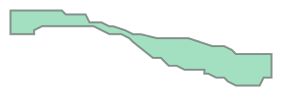

In [15]:
gdf = gpd.read_file(shp)
feat = gdf.iloc[0]
polygon = feat.geometry
polygon

In [16]:

polygon = feat.geometry
buffer = (polygon.area**0.5)/2
buffer = 5
mbr = polygon.minimum_rotated_rectangle.buffer(10)
bounds = mbr.envelope.buffer(buffer).bounds

xmin, ymin, xmax, ymax = bounds
extent = (xmin, xmax, ymin, ymax)


In [1]:
import numpy as np
import rasterio
from rasterio.windows import from_bounds
from rasterio.io import MemoryFile
from rasterio.features import geometry_mask
from rasterio.mask import mask
import matplotlib.pyplot as plt
from matplotlib import colors
from pysheds.grid import Grid

# Open DEM data
with rasterio.open(dem_tif) as src:
    window = from_bounds(*bounds, transform=src.transform)
    # Read DEM data within the window subset
    subsetDemData = src.read(1, window=window)
    transform = src.window_transform(window)
    width, height = window.width, window.height
    nodata_value = src.nodata
    dtype = src.dtypes[0]

    clipped_raster, clipped_transform = mask(src, [polygon], crop=True)
    # Convert NoData values to np.nan
    clipped_raster = clipped_raster.astype(np.float32)
    clipped_raster[clipped_raster == src.nodata] = np.nan

    print('clipped_raster: ', clipped_raster)
    clipped_raster_height, clipped_raster_width = clipped_raster.shape[1], clipped_raster.shape[2]

    # Update metadata for the clipped raster
    clipped_meta = src.meta.copy()
    clipped_meta.update({
        "height": clipped_raster_height,
        "width": clipped_raster_width,
        "transform": clipped_transform,
        "dtype":np.float32
    })

    with MemoryFile() as memFile:
        # Create a new raster dataset
        with memFile.open(**clipped_meta) as memSrc:
            # Write the accumulation data to the raster band
            memSrc.write(clipped_raster[0], 1)
            clipped_dem = memSrc.read(1)

            grid = Grid.from_raster(memFile.name)
            dem = grid.read_raster(memFile.name)

            # Condition DEM
            # ----------------------
            # Fill pits in DEM
            pit_filled_dem = grid.fill_pits(dem)

            # Fill depressions in DEM
            flooded_dem = grid.fill_depressions(pit_filled_dem)

            # Resolve flats in DEM
            inflated_dem = grid.resolve_flats(flooded_dem)


            # Determine D8 flow directions from DEM
            # Specify directional mapping
                    #N   NE   E  SE S  SW W   NW
            dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

            # Compute flow directions
            fdir = grid.flowdir(inflated_dem, dirmap=dirmap)


            # Calculate flow accumulation
            acc = grid.accumulation(fdir, dirmap=dirmap)

            (x, y) = polygon.centroid.x, polygon.centroid.y
            y_snap, x_snap = np.unravel_index(np.argmax(acc), acc.shape)
            catch = grid.catchment(x=x_snap , y=y_snap, fdir=fdir, xytype='index')
            print((x, y) , (y_snap, x_snap), catch)

            # Snap pour point to high accumulation cell
            # x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

            # Delineate the catchment
            # catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
            #                       xytype='coordinate')

            #shapes = grid.polygonize()

            # Extract the river network
            # Extract river network
            # ---------------------
            branches = grid.extract_river_network(fdir, acc > 2, dirmap=dirmap)


            # PLOT
            fig, axes = plt.subplots(2, 2, figsize=(8, 4))

            ax1 = axes[0,0]
            im1 = ax1.imshow(subsetDemData, extent=(xmin, xmax, ymin, ymax) , cmap='gray', zorder=1)
            xs, ys = polygon.exterior.xy
            ax1.plot(xs,ys, c='red', linewidth=3, zorder=10)

            plt.colorbar(im1, ax=ax1, label='Elevation')

            _xmin, _ymin, _xmax, _ymax = memSrc.bounds

            ax2 = axes[0,1]
            im2 = ax2.imshow(clipped_dem, extent=(_xmin, _xmax, _ymin, _ymax) , cmap='gray', vmin=np.nanmin(clipped_raster), vmax=np.nanmax(clipped_raster), zorder=1)
            ax2.plot(xs,ys, c='red', linewidth=2, zorder=10)
            plt.colorbar(im2, ax=ax2, label='Elevation')

            ax3 = axes[1,0]
            im3 = ax3.imshow(acc, extent=(_xmin, _xmax, _ymin, _ymax), zorder=1, cmap='cubehelix', norm=colors.LogNorm(1, acc.max()), interpolation='bilinear')

            plt.colorbar(im3, ax=ax3, label='Upstream Cells')


            ax4 = axes[1,1]
            ax4.set_xlim (xmin, xmax)
            ax4.set_ylim (ymin, ymax)
            for branch in branches['features']:
                line = np.asarray(branch['geometry']['coordinates'])
                ax4.plot(line[:, 0], line[:, 1])
            ax4.plot(xs,ys, c='red', linewidth=3, zorder=10)

            plt.axis('equal')
            plt.show()




ModuleNotFoundError: No module named 'rasterio'